In [1]:
# | default_exp diff_scratch

%load_ext autoreload
%autoreload 2

%env PYDEVD_DISABLE_FILE_VALIDATION=1

env: PYDEVD_DISABLE_FILE_VALIDATION=1


# Diffusion model from scratch

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,Subset
#from diffusers import DDPMScheduler, UNet2DModel
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from matplotlib import pyplot as plt
from icecream import ic
import numpy as np
from datetime import datetime
from cop_diffusion.utils import save_model, load_model

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
train_dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

ic| 'Input shape:', x.shape: torch.Size([8, 1, 28, 28])
ic| 'Labels:', y: tensor([3, 9, 8, 0, 1, 6, 9, 6])


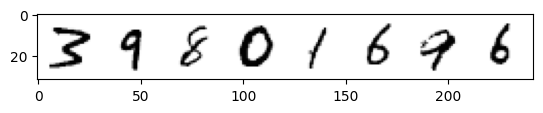

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
oh_y = torch.nn.functional.one_hot(y)
ic("Input shape:", x.shape)
ic("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")


## Corruption process

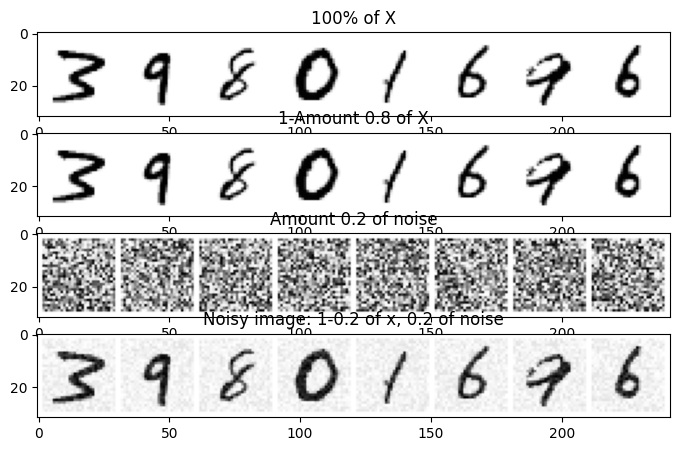

In [5]:
noise = torch.rand_like(x)
amount = .2
x_noisy = (1-amount)*x + amount*noise


fig, axs = plt.subplots(4, 1, figsize=(15, 5))
axs[0].set_title("100% of X")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

axs[1].set_title(f"1-Amount {1-amount} of X")
axs[1].imshow(torchvision.utils.make_grid(x*(1-amount))[0], cmap="Greys")

axs[2].set_title(f"Amount {amount} of noise")
axs[2].imshow(torchvision.utils.make_grid(noise*amount)[0], cmap="Greys")


axs[3].set_title(f"Noisy image: 1-{amount} of x, {amount} of noise")
axs[3].imshow(torchvision.utils.make_grid(x_noisy)[0], cmap="Greys")

In [6]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


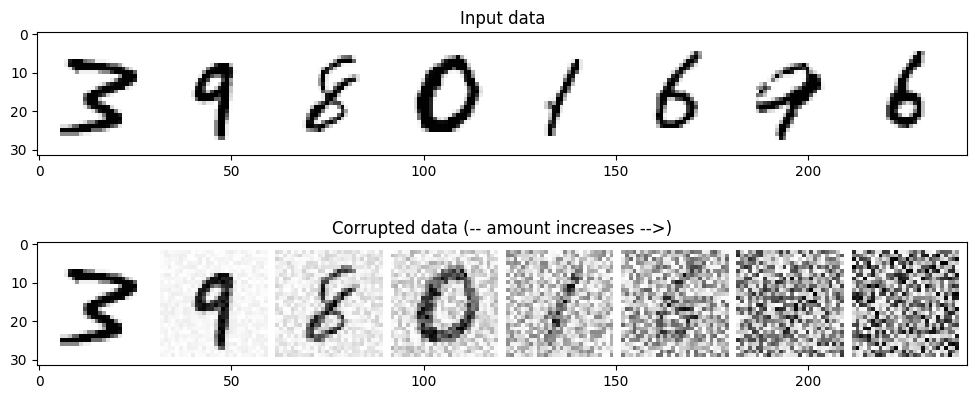

In [7]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])
print(amount)  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

## Model to learn noise

We’d like a model that takes in a 28px noisy images and outputs a prediction of the same shape.

**UNet** consists of a ‘constricting path’ through which data is compressed down and an ‘expanding path’ through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

![UNET](../res/unet.png)


### See convolution_101.ipynb for better understanding of convolutions

![Convolution_101](./convolution_101.ipynb)


In [8]:
y.shape

torch.Size([8])

ic| t.shape: torch.Size([8]), y.shape: torch.Size([8])
ic| ux.shape: torch.Size([8, 1, 28, 28])
    x.shape: torch.Size([8, 1, 28, 28])
ic| torchvision.utils.make_grid(x.cpu())[0].shape: torch.Size([32, 242])


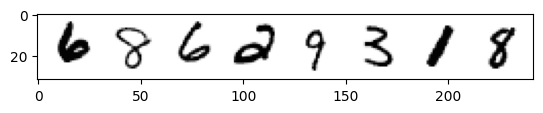

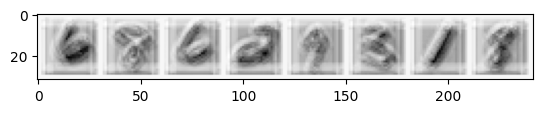

In [9]:
class BasicUNet(nn.Module):
    def __init__(self, ctx_nb_feats:int, in_channels:int=1, out_channels:int=1):
        super().__init__()
        self.d1 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.d2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.d3 = nn.Conv2d(128, 256, kernel_size=5, padding=2)

        self.u1= nn.Conv2d(256, 128, kernel_size=5, padding=2)
        self.u2= nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.u3= nn.Conv2d(64, out_channels, kernel_size=5, padding=2)

        self.ce2 = nn.Embedding(ctx_nb_feats,128)
        self.te2 = nn.Embedding(1,128)

        self.ce3 = nn.Embedding(ctx_nb_feats,64)
        self.te3 = nn.Embedding(1,64)

        self.act = nn.SiLU()
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)


    def forward(self, x, t, c=None):
        xd1 = self.act(self.d1(x))
        xmd1 = self.downsample(xd1)
        xd2 = self.act(self.d2(xmd1))
        xmd2 =self.downsample(xd2)
        xd3 = self.act(self.d3(xmd2))

        xu1 = self.act(self.u1(xd3))
        xus2 = self.upsample(xu1)
        xus2 = xus2 + xd2
        h2_dim  = xus2.shape[1] # the dim of hidden
        t2_emb = self.te2(t).view(-1, h2_dim, 1,1)
        c2_emb = self.ce2(c).view(-1, h2_dim, 1,1)
        xus2 = c2_emb * xus2 + t2_emb
        xu2 = self.act(self.u2(xus2))

        xus3 = self.upsample(xu2)
        xus3 = xus3 + xd1
        h3_dim  = xus3.shape[1] # the dim of hidden
        t3_emb = self.te3(t).view(-1, h3_dim, 1,1)
        c3_emb = self.ce3(c).view(-1, h3_dim, 1,1)
        xus2 = c3_emb * xus3 + t3_emb
        xu3 = self.act(self.u3(xus3))

        return xu3

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
model = BasicUNet(ctx_nb_feats=9).to(device)
#x = torch.rand(8, 1, 28, 28)
t = torch.zeros(x.shape[0]).long().to(device)
#oh_y = oh_y.to(device)
x = x.to(device)
y = y.long().to(device)
ic(t.shape, y.shape)
ux = model(x,t, y)
ic(ux.shape, x.shape)
ic(torchvision.utils.make_grid(x.cpu())[0].shape)
plt.imshow(torchvision.utils.make_grid(x.cpu())[0], cmap="Greys")
plt.show()
plt.imshow(torchvision.utils.make_grid(ux.cpu())[0], cmap="Greys")
plt.show()

### Understand the UNET

In [10]:
def show_channel(input, channel_nb:int=0, info=""):
    '''You must provide on image of shape (batch, channel, height, width)convolved on many channels'''
    title = f"channel {channel_nb}, info: {info}"
    img = input[channel_nb].cpu().detach().numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")  # Turn off axis labels
    plt.show()

ic| x.shape: torch.Size([8, 1, 28, 28])
ic| c0.shape: torch.Size([8, 32, 28, 28])
ic| cd0.shape: torch.Size([8, 32, 14, 14])


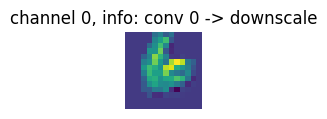

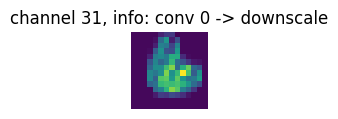

ic| cd1.shape: torch.Size([8, 64, 7, 7])


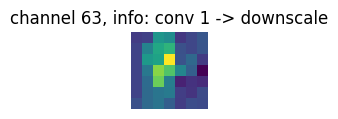

ic| u0.shape: torch.Size([8, 64, 14, 14])


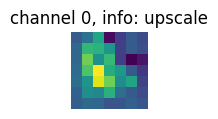

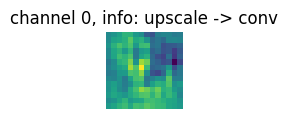

In [11]:
in_channels=1
out_channels=1
ic(x.shape)
c0 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2).to(device)(x)
ic(c0.shape);
downscale = nn.MaxPool2d(2).to(device)
cd0 = downscale(c0)
ic(cd0.shape)
show_channel(cd0[0],channel_nb=0, info='conv 0 -> downscale' )
show_channel(cd0[0],channel_nb=31, info='conv 0 -> downscale' )


c1 = nn.Conv2d(32, 64, kernel_size=5, padding=2).to(device)(cd0)
cd1 = downscale(c1)
ic(cd1.shape)
show_channel(cd1[0], channel_nb=63,info='conv 1 -> downscale' )

# Decoding part
upscale = nn.Upsample(scale_factor=2).to(device)
u0 = upscale(cd1)
ic(u0.shape)
show_channel(u0[0],channel_nb=0, info='upscale')
uc0 = nn.Conv2d(64, 64, kernel_size=5, padding=2).to(device)(u0)
show_channel(uc0[:,0],channel_nb=0, info='upscale -> conv')


### Train the UNet model (DDPM)

https://github.com/nickd16/Diffusion-Models-from-Scratch


- Beta $\beta$, control the noise added at each step. Beta is the noise schedule, the variance of noised added (between 0..1) at each t
- Alpha $\alpha$, control the noise removed at each step $\alpha_t = 1-\beta_t$. This is the **signal retention** 

Choosing the beta schedule is key in the process. It can be
- linear: increase linearly over timestep
- cosine: follow a cosine function, start slowly, increase rapidly, slow down again. Often better perf. 
- quadratic or other non linear schedules. 

#### Forward

Gradually add noise to image over serie of timesteps 
$x_t = \sqrt{\alpha_{\text{cumprod}t}} \cdot x_0 + \sqrt{1 - \alpha{\text{cumprod}_t}} \cdot \epsilon$

- $\epsilon$ : the gaussian noise
- $x_0$: original image
- $\alpha = 1 - \beta $
- $\alpha_{cumprod_t}$ cumulative product up to time step t. Represent how much of the original image remains after t steps.


#### Reverse diffusion (Denoising)
 iteratively remove the noise added in forward process to reconstruct original image from noisy image. Trained model predict the noise.

 It incorporate posterior variance, randomnsess that prevent exact reconstruction. 



1. Estimate what a clean desk would be without the mess. Mentally subtract the mess. So we directly estimate the original image from the noisy one at timestep t. In diffusion model, we don't use it. 
$\hat{x}0 = \frac{x_t - \sqrt{1 - \alpha{\text{cumprod}t}} \cdot \epsilon{\theta}(x_t, t)}{\sqrt{\alpha_{\text{cumprod}_t}}}$

- $\epsilon{\theta}(x_t,t)$: the model prediction of the noise added at timestep t
- $\alpha{\text{cumprod}t}$: how much of the original signal remains.

2. Transition to a less messy desk, by using smooth transitions. 
$x_{t-1} = \sqrt{\frac{1}{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \alpha_{\text{cumprod}t}}} \cdot \epsilon{\theta}(x_t, t) \right) + \sqrt{\beta_t} \cdot \epsilon$


ic| x_noisy.shape: torch.Size([8, 1, 28, 28])
    noise.shape: torch.Size([8, 1, 28, 28])


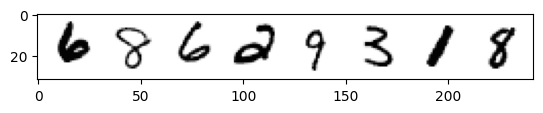

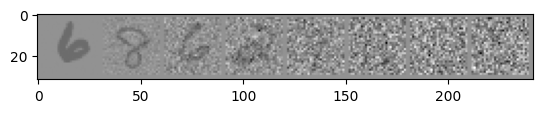

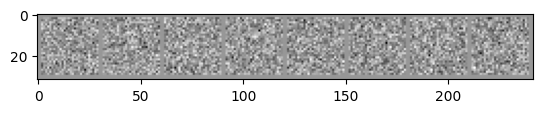

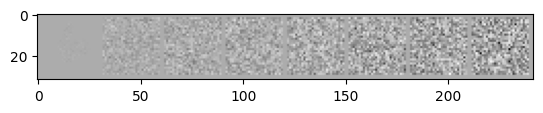

In [30]:
class DDPMScheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000, beta_start:float=1e-4, beta_end:float=0.02, device:str='cpu'):
        super().__init__()
        self.num_time_steps = num_time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, num_time_steps, requires_grad=False).to(device)
        self.alphas = 1 - self.betas
        # cumulative product of alphas upto time t, quantiies the amount of info retained at time t in the forward diffusion process
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).requires_grad_(False)
        # special case: t=0, no previous timestep
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alphas_cumprod[:-1]]).requires_grad_(False)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alphas_cumprod).to(device)
        self.sqrt_reciprocal_alphas = torch.sqrt(1.0 / self.alphas).to(device)

        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def add_noise_step(self, x, t) -> tuple[torch.Tensor, torch.Tensor]:
        """Gradually add noise to the image
        """
        sqrt_alpha_cum_prod_t = self.sqrt_alpha_cumprod[t].view(-1,1,1,1)
        sqrt_one_minus_alpha_cum_prod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
        noise = torch.randn_like(x).to(self.device)
        noisy_x = sqrt_alpha_cum_prod_t * x + sqrt_one_minus_alpha_cum_prod_t * noise
        return noisy_x, noise

    def denoise_step(self, pred_noise, x_noisy, t):
        """ estimage previous image $x_{t-1}$
        As it incorporate posterior variance, randomnsess that prevent exact reconstruction.
        """

        # we get value at time t
        sqrt_reciprocal_alpha_t = self.sqrt_reciprocal_alphas[t].view(-1,1,1,1)
        sqrt_one_minus_alpha_cum_prod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
        beta_t = self.betas[t].view(-1,1,1,1)
        posterior_variance_t = self.posterior_variance[t].view(-1,1,1,1)

        # Compute the mean of the posterior q(x_{t-1} | x_t, x_0)
        # Using the DDPM reverse process mean formula
        pred_mean = sqrt_reciprocal_alpha_t * (x_noisy * beta_t * pred_noise) / sqrt_one_minus_alpha_cum_prod_t

        # sample noise for the next step to avoid collaps of model.
        z = torch.randn_like(x_noisy).to(self.device)
        x_prev = pred_mean + torch.sqrt(posterior_variance_t)* z
        return x_prev




scheduler = DDPMScheduler(num_time_steps=500, device=device)

t = torch.tensor([0,50, 100, 150, 200,300,400,499]).to(device)
assert t.shape[0]==x.shape[0], "it should be the same nb of examples"
x_noisy, noise = scheduler.add_noise_step(x, t)
ic(x_noisy.shape, noise.shape)
plt.imshow(torchvision.utils.make_grid(x.cpu())[0], cmap="Greys")
plt.show()

plt.imshow(torchvision.utils.make_grid(x_noisy.cpu())[0], cmap="Greys")
plt.show()

plt.imshow(torchvision.utils.make_grid(noise.cpu())[0], cmap="Greys")
plt.show()


denoised_x = scheduler.denoise_step(noise, x_noisy, t)
plt.imshow(torchvision.utils.make_grid(denoised_x.cpu())[0], cmap="Greys")
plt.show()


In [14]:
# create a very tiny dataset to overfit the training and validate the model has enough capacity to have a loss of 0.
random_indices = torch.randperm(len(train_dataset))[:10]
train_tiny_dataset = Subset(train_dataset, random_indices)


In [ ]:
def compute_grad_norm(model) -> float:
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)  # Compute L2 norm of gradients
            total_norm += param_norm.item() ** 2  # Square the norms and accumulate

    total_norm = total_norm ** 0.5
    return total_norm

compute_grad_norm(model)

In [ ]:
num_time_steps = 500
scheduler = DDPMScheduler(num_time_steps=num_time_steps, device=device)
# as alpha and beta are not learned nn.parameters they are not moved to device, if you do scheduler.to(device)
scheduler.betas = scheduler.betas.to(device)
scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)

batch_size = 128

use_tiny_dataset = True
do_train:bool=True
if use_tiny_dataset:
    n_epoch = 20

else:
    n_epoch = 5
last_epoch = 0

model_version = "0.2"
model_name = f"mnist_{'tiny_' if use_tiny_dataset else ''}ddpm_time_emb"

if do_train:
    if use_tiny_dataset:
        train_dataloader = DataLoader(train_tiny_dataset, batch_size=5, shuffle=True)
    else:
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if last_epoch > 0:
        model = load_model(
            model_name=model_name, model_version=model_version, iter=last_epoch
        )
        from_epoch_nb = last_epoch + 1
    else:

        model = BasicUNet(ctx_nb_feats=9).to(device)
        from_epoch_nb = 0

    writer = SummaryWriter(
            f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
        )
    log_interval:int=50
    # The training loop
    criterion = nn.MSELoss(reduction='mean')#.to(device)
    lr=2e-5
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    nb_batches = len(train_dataloader)
    with tqdm(
        total=(n_epoch+1-from_epoch_nb) * nb_batches,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        grad_norms = []
        for epoch in range(from_epoch_nb, n_epoch+1):
            total_loss = 0
            for batch_nb, (x, y) in enumerate(train_dataloader):
                x = x.to(device)
                y = y.long().to(device)

                b = x.size(0)
                t = torch.randint(0, num_time_steps,(b,)).to(device)
                x_noisy, noise  = scheduler.add_noise_step(x,t )
                x_noisy= x_noisy.to(device)

                # we may exhaust the loader and have a smaller batch
                output = model(x_noisy,t,y)
                optimizer.zero_grad()
                loss = criterion(output, noise)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

                i = (epoch*nb_batches) + batch_nb
                writer.add_scalar(f"train loss", loss.item(), (epoch*nb_batches) + batch_nb)
                if i % log_interval == 0:
                    for name, kernel_weight in model.named_parameters():
                        if kernel_weight.numel() > 0:
                            writer.add_histogram(name, kernel_weight, i)

                    # compute gradient norm
                    grad_norm = compute_grad_norm(model)
                    grad_norms.append(grad_norm)
                    writer.add_histogram("grad norm", grad_norm, i)

                pbar.update(1)
                pbar.set_postfix({
                        "epoch": epoch,
                        "batch_nb": batch_nb,
                        "train_loss": f"{loss.item():.4f}",
                    })
                ...
        if not use_tiny_dataset:
            save_model(model=model, model_name=model_name, model_version=model_version, iter=epoch)
else:
    if not use_tiny_dataset:
        model = load_model(model_name=model_name, model_version=model_version, iter=last_epoch)

In [1]:
# visualize histograms
# plot in tensorboard.
plt.figure(figsize=(20, 4))
legends = []
for name, param in model.named_parameters():
    if param.grad is not None:
        g = param.grad
        m_g = g.mean()
        std_g = g.std()
        hy, hx = torch.histogram(g, density=True)
        plt.plot(hx[:-1].cpu().detach(), hy.cpu().detach())
        legends.append(f"layer {name}")

plt.legend(legends)


NameError: name 'plt' is not defined

### Remarks
- it look loss get to 0.45 after 10 epochs and stay there
- with this model with a tiny dataset (10 examples) it cannot go lower than 0.45 after 1000 or 5000 epochs
- Enhance the model by adding capacity and by checking it overfit to 0 loss with a very small dataset (like 5 samples)


In [ ]:
n_sample = 5
h,w = 28,28

def show_images(imgs_tensor):
    grid =torchvision.utils.make_grid(imgs_tensor.cpu())
    plt.imshow(grid.permute(1, 2, 0)[:,:,0], cmap="Greys")
    plt.show()

with torch.no_grad():
    ctx = torch.tensor([0,1,2,3,4]).to(device)
    samples = torch.randn(n_sample,1,h,w).to(device)
    ic(samples.size())
    for i in range(num_time_steps, 0,-1):
        t = torch.tensor([i]*n_sample).to(device)
        pred_noise = model(samples,t,ctx)
        samples = scheduler.denoise_step(samples,t,pred_noise)
        #ic(samples.size())
        show_images(pred_noise)
        if i<496:

            break


In [ ]:

    for i in range(n_sample, 0, -1):
        t = torch.randint(i, num_time_steps,(b,)).to(device)
        ctx = torch.tensor([1]).to(device)

        pred_noise = model(samples, t, ctx)
        pred_noise(sample)

In [ ]:
pred_noise

In [ ]:
def display_reverse(images: list):
    fig, axes = plt.subplots(1, len(images), figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        #x = torch.rearrange(x, 'c h w -> h w c')
        x = x.permute(1,2,0)
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

scheduler = DDPMScheduler(num_time_steps=num_time_steps)
times = [0,15,50,100,200,300,400,499]
images = []
with torch.no_grad():
    model = model.eval()
    for i in range(10):
        z = torch.randn(1, 1, 32, 32)
        for t in reversed(range(1, num_time_steps)):
            t = [t]
            temp = (scheduler.betas[t]/( (torch.sqrt(1-scheduler.alphas_cumprod[t]))*(torch.sqrt(1-scheduler.betas[t])) ))
            z = (1/(torch.sqrt(1-scheduler.betas[t])))*z - (temp*model(z.to(device),t=[0]).cpu())
            if t[0] in times:
                images.append(z)
            e = torch.randn(1, 1, 32, 32)
            z = z + (e*torch.sqrt(scheduler.betas[t]))
        temp = scheduler.betas[0]/( (torch.sqrt(1-scheduler.alphas_cumprod[0]))*(torch.sqrt(1-scheduler.betas[0])) )
        y = torch.randint(0,9,(1,1)).to(device)
        z_pred =model(z.to(device),t=[0],c=y)
        ic(z_pred.shape)
        x = (1/(torch.sqrt(1-scheduler.betas[0])))*z - (temp*z_pred.cpu())

        images.append(x)
        #x = torch.rearrange(x.squeeze(0), 'c h w -> h w c').detach()
        ic(x.shape, x.squeeze(0).shape)
        x = x.squeeze(0).permute( 1,2,0).detach()
        x = x.numpy()
        plt.imshow(x)
        plt.show()
        display_reverse(images)
        images = []

### Train the UNet model

Difference with DDPM method.

The training objective is different, involving predicting the noise rather than the denoised image

The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.

In [ ]:
model_version = "0.1"
model_name = "mnist_diffus"


# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epoch = 3

# Create the network
model = BasicUNet()
model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

do_train: bool = True
last_update_epoch = 0

if do_train:
    writer = SummaryWriter(
        f"../runs/{model_name}_{model_version}/{datetime.now().strftime('%m-%d-%Y_%H:%M:%S')}"
    )
    # The training loop
    nb_batches = len(train_dataloader)
    with tqdm(
        total=n_epoch * nb_batches,
        desc=f"Training update",
        unit="batch",
    ) as pbar:
        for epoch in range(n_epoch):
            for batch_nb, (x, y) in enumerate(train_dataloader):
                # Get some data and prepare the corrupted version
                x = x.to(device)  # Data on the GPU
                noise_amount = torch.rand(x.shape[0]).to(
                    device
                )  # Pick random noise amounts
                x_noisy = corrupt(x, noise_amount)  # Create our noisy x

                # Get the model prediction
                pred = model(x_noisy)

                # Calculate the loss
                loss = loss_fn(
                    pred, x
                )  # How close is the output to the true 'clean' x?

                # Backprop and update the params:
                opt.zero_grad()
                loss.backward()
                opt.step()

                # Store the loss for later
                losses.append(loss.item())

                pbar.update(1)
                pbar.set_postfix(
                    {
                        "epoch": epoch,
                        "batch_nb": batch_nb,
                        "train_loss": f"{loss.item():.4f}",
                    }
                )
                writer.add_scalar(f"train loss", loss.item(), (epoch*nb_batches) + batch_nb)

            for name, kernel_weight in model.named_parameters():
                writer.add_histogram(name, kernel_weight, epoch)

            # Print our the average of the loss values for this epoch:
            avg_loss = sum(losses[nb_batches :]) / nb_batches
            # print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.25)


    save_model(model=model, model_name=model_name, model_version=model_version, iter=epoch)
else:
    model = load_model(model_name=model_name, model_version=model_version, iter=last_update_epoch)


In [ ]:
# Reconstruction without any noise added.

dl = DataLoader(train_dataset, batch_size=8, shuffle=True)
x, y = next(iter(dl))
with torch.no_grad():
    ux = model(x.to(device))
    ic(ux.shape)

fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
axs[1].set_title("Reconstructed")
axs[1].imshow(torchvision.utils.make_grid(ux.cpu())[0], cmap="Greys")

In [ ]:
# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

In [ ]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = model(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")